In [1]:
import os
import re
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import ast
import json
from glob import glob

In [5]:
folder_ped = '/home/sogangori/Downloads/PennFudanPed/'
folder_rgb = 'PNGImages/'
folder_mask = 'PedMasks/'

In [7]:
os.path.isdir(folder_ped), os.path.isdir(folder_ped+folder_rgb), os.path.isdir(folder_ped+folder_mask)

(True, True, True)

In [235]:
padded_image_shape = (1024, 1920)
num_classes = 80#
num_classes_real = 5
class_names = ['bg', '"water"', '"waterf"', '"land"', '"animal"']
max_data_m = 5000
use_zoom_up_data = False
level_start = 3
level_end = 8
l1 = 1e-7
activation = 'relu'
edgecolors = np.random.rand(num_classes, 3) 
edgecolors = np.minimum(edgecolors+0.1, 1.0)

In [29]:
path_rgbs = glob(folder_ped + folder_rgb + '*.*')
len(path_rgbs), path_rgbs[0], path_rgbs[-1]

(170,
 '/home/sogangori/Downloads/PennFudanPed/PNGImages/PennPed00068.png',
 '/home/sogangori/Downloads/PennFudanPed/PNGImages/FudanPed00037.png')

In [27]:
def convert_path_rgb_to_path_mask(path_rgb):
    path_file_name = path_rgb.split('/')[-1]
    file_name_pre = path_file_name.split('.')[0]
    path_mask = folder_ped + folder_mask + file_name_pre + '_mask' + '.png'
    if os.path.isfile(path_mask):
        return path_mask
    else:
        print('not exist file', path_mask)
        exit()

In [33]:
path_masks = []
for path_rgb in path_rgbs:
    path_masks.append(convert_path_rgb_to_path_mask(path_rgb))
print(len(path_rgbs), len(path_masks))

170 170


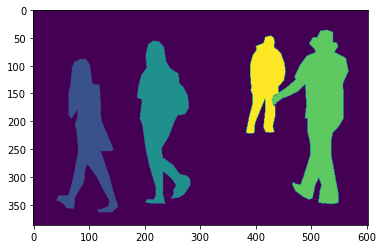

In [86]:
plt.imshow(Image.open(path_masks[0]))

In [116]:
arr_mask = np.array(Image.open(path_masks[0]))
arr_mask.shape

(387, 603)

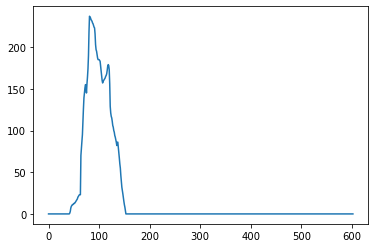

In [127]:
sum_row = np.sum(arr_mask==1, axis=0)
plt.plot(sum_row)

In [142]:
np.argmax((sum_row>0).astype(np.int)), np.argmax((sum_row[::-1]>0).astype(np.int))

(42, 450)

In [159]:
np.argmax((sum_row>0).astype(np.int)), 603-np.argmax((sum_row[::-1]>0).astype(np.int))

(42, 153)

In [145]:
(sum_row[::-1]>0).astype(np.int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [208]:
def get_masked_pedestrian(path_rgbs, path_masks):
    arr_ped_list = []
    m = len(path_rgbs)
    for i in range(m):
        path_rgb = path_rgbs[i]
        path_mask = path_masks[i]
        img_rgb = Image.open(path_rgb)
        img_mask = Image.open(path_mask)
        arr_rgb = np.array(img_rgb)
        arr_mask = np.array(img_mask)
        mask_max_v = np.max(arr_mask)
        img_h, img_w = arr_mask.shape
        #print(i, 'mask_max_v', mask_max_v, np.unique(arr_mask), 'img_h, img_w', img_h, img_w)
        if np.min(arr_rgb) < 1:
            #print('rgb min value is', np.min(arr_rgb), np.max(arr_rgb), path_rgb)
            arr_rgb = np.maximum(arr_rgb, np.ones_like(arr_rgb))
            
        arr_mask_3d = np.expand_dims((arr_mask > 0).astype(np.uint8), -1)
        arr_rgb_masked = arr_rgb * arr_mask_3d
        for j in range(1, 1 + mask_max_v):
            ped_mask_j = arr_mask == j
            ped_mask_sum_0 = np.any(ped_mask_j, axis=0)
            ped_mask_sum_1 = np.any(ped_mask_j, axis=1)
            ped_mask_sum_0 = ped_mask_sum_0.astype(np.int)
            ped_mask_sum_1 = ped_mask_sum_1.astype(np.int)
           
            x0 = np.argmax(ped_mask_sum_0)
            x1 = img_w - np.argmax(ped_mask_sum_0[::-1])
            y0 = np.argmax(ped_mask_sum_1)
            y1 = img_h - np.argmax(ped_mask_sum_1[::-1])            
            #print(ped_mask_j.shape, np.sum(ped_mask_j), x0, x1, y0, y1)            
            arr_ped_j = arr_rgb_masked[y0:y1, x0:x1]
            arr_ped_list.append(arr_ped_j)
        
        if i%100==0:print(i, len(arr_ped_list))
    return arr_ped_list

0 4
100 256
len 423


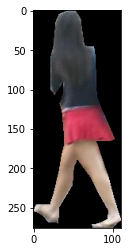

In [214]:
ped_list = get_masked_pedestrian(path_rgbs, path_masks)
print('len', len(ped_list))
p = plt.imshow(ped_list[0]) 

In [218]:

def attach_obj(crop_obj_list, cls_list, resize_w=32, resize_h=48):
    m = len(crop_obj_list)    
    img_h = padded_image_shape[0]
    img_w = padded_image_shape[1]
    row = img_h//resize_h
    col = img_w//resize_w
    img_m = (m - 1) // (row * col) + 1
    canvas = np.zeros((img_m, img_h, img_w, 3), dtype=np.uint8)
    cbbox_list = []
    for i in range(img_m):
        cbbox_list.append([])
    print('canvas', canvas.shape, row, col)
    cls_sort_index = np.argsort(cls_list)
    for j in range(m):
        i = cls_sort_index[j]
        x = crop_obj_list[i]
        cls = cls_list[i]
        #print(i, x.shape)
        arr = x.astype(np.uint8)
        img = Image.fromarray(arr)
        img = img.resize((resize_w, resize_h))
        x = np.array(img)
        tm = i // (row * col)
        ty = (i % (row * col) )// col
        tx = i % col
        #print(i, tm, ty, tx)
        x0 = tx*resize_w
        x1 = (tx+1)*resize_w
        y0 = ty*resize_h
        y1 = (ty+1)*resize_h
        canvas[tm, y0:y1, x0:x1] = x
        
        cbbox_list[tm].append(np.array([cls, 1.0*x0/img_w, 1.0*y0/img_h, 1.0*x1/img_w, 1.0*y1/img_h]))
        
    for i in range(img_m):
        cbboxs = cbbox_list[i]
        cbbox_list[i] = np.stack(cbboxs, axis=0)
    return canvas, cbbox_list

In [236]:
def crop_bbox_image(image, boxes):
    img_objects = []
    image = np.array(image)
    for box in boxes:        
        box = box.astype(np.int)
        x1, y1, x2, y2 = box
        w = x2 - x1
        h = y2 - y1        
        crop_image_arr = image[y1:y2, x1:x2]
        ch, cw, cc = crop_image_arr.shape
        if ch>1 and cw>1:
            img_objects.append(crop_image_arr)
        else:
            print('crop_bbox_image', x2-x1, y2-y1, 'crop_image_arr.shape', crop_image_arr.shape)
        
    return img_objects
    
    
def attach_crop_image(image, boxes, max_crop=200):
        
    crop_bbox_arr = crop_bbox_image(image, np.array(boxes)[:max_crop])
    bbox_k = len(crop_bbox_arr)
    max_col = 30
    
    if bbox_k > 0:
        img_h, img_w, img_c = image.shape
        object_img_w = img_w//bbox_k        
        resize_h = img_h // 8
        resize_w = img_w // bbox_k  
        resize_w = min(max(resize_w, img_w//max_col), img_w//8)
        
        footer_h = resize_h * (1 + (bbox_k-1)//max_col)
        footer = np.zeros((footer_h, img_w, img_c), np.uint8)
        
        for i in range(min(bbox_k, max_crop)):
            crop_arr = crop_bbox_arr[i]
            crop_img = Image.fromarray(crop_arr)                
            crop_img = crop_img.resize((resize_w, resize_h))
            crop_arr_resized = np.array(crop_img)
            offset_y = (i//max_col) * resize_h
            offset_x = (i%max_col) * resize_w
            footer[offset_y:offset_y+resize_h, offset_x:offset_x+resize_w] = crop_arr_resized

        seperate_line = np.zeros_like(footer[:2])
        image = np.concatenate((image, seperate_line, footer), axis=0)    
    return image    

In [237]:
def visualize_detections_simple(
    image, boxes, classes, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)    
    
    img_h, img_w, img_c = image.shape
    
    image = attach_crop_image(image, boxes, max_crop=100)
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    boxes_width = boxes[:, 2] - boxes[:, 0]
    boxes_height = boxes[:, 3] - boxes[:, 1]
    box_min_width = np.min(boxes_width)
    box_max_width = np.max(boxes_width)
    title = str.format('(%dx%d) %d box, width:%d ~ %d' 
                       %(img_h, img_w, len(boxes), box_min_width, box_max_width))
    plt.title(title)
    for box, cls in zip(boxes, classes):
        x1, y1, x2, y2 = box        
        w, h = x2 - x1, y2 - y1
        color = edgecolors[int(cls)]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        if len(boxes) < 100:
            score_txt = class_names[int(cls)]
            ax.text(x1, y1, score_txt, bbox={"facecolor": [1,1,0], "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
        
    plt.show()
    return ax

def display_data(X, BBOX, stride=1):
    for i in range(len(X)):
        if i%stride==0:
            img_arr = X[i]
            sample_box = BBOX[i]
            label = sample_box[:, 0]
            bbox = sample_box[:, 1:]

            h, w, c = img_arr.shape
            scale = np.array((w, h, w, h))
            scale = np.reshape(scale, (1, 4))
            bbox_norm = bbox.astype(np.float) * scale.astype(np.float)
            #print('bbox_norm', bbox, bbox_norm)
            print(i, np.unique(label))
            ax = visualize_detections_simple(img_arr,bbox_norm,label)

In [238]:
attach_obj_img, attach_obj_bbox = attach_obj(ped_list, np.zeros_like(ped_list), resize_w=64*2, resize_h=2*100)

canvas (6, 1024, 1920, 3) 5 15


0 [0.]


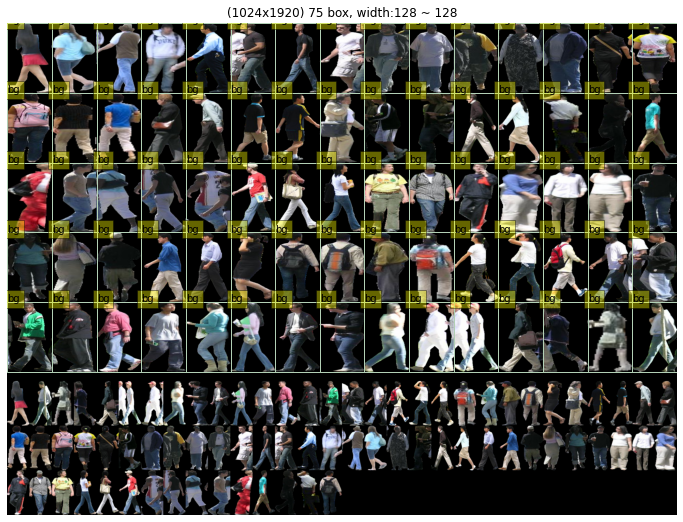

1 [0.]


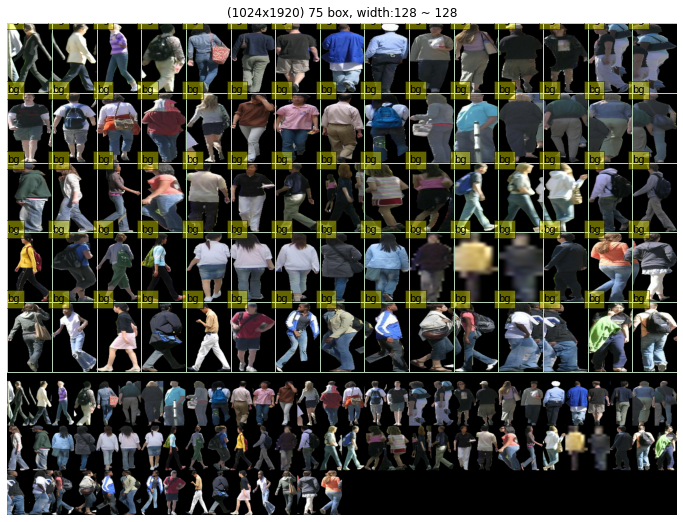

2 [0.]


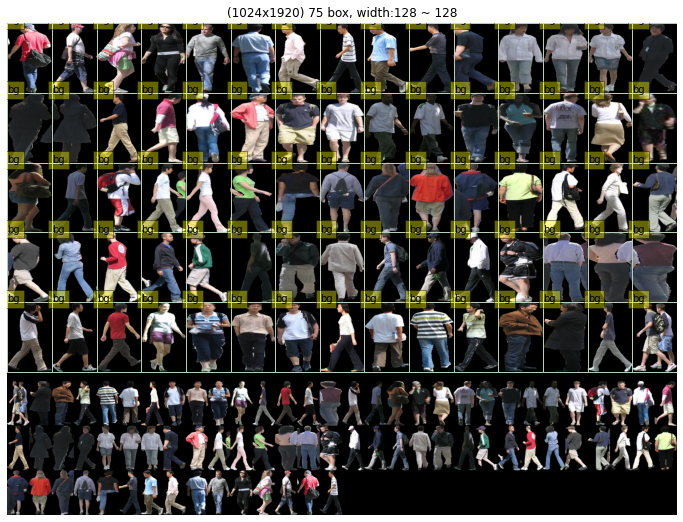

3 [0.]


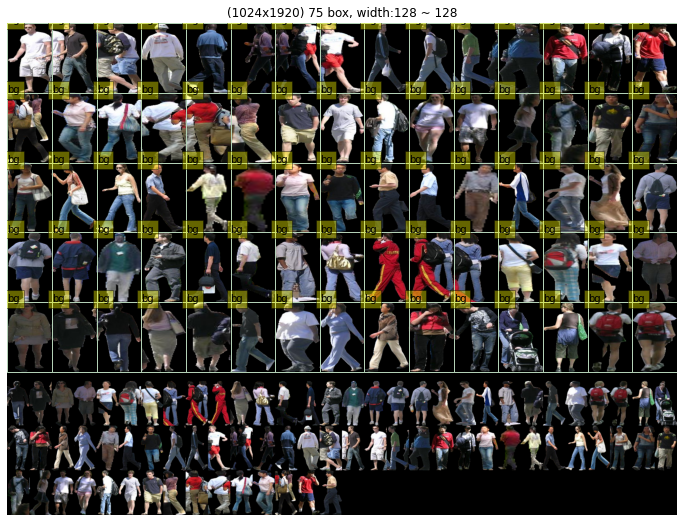

4 [0.]


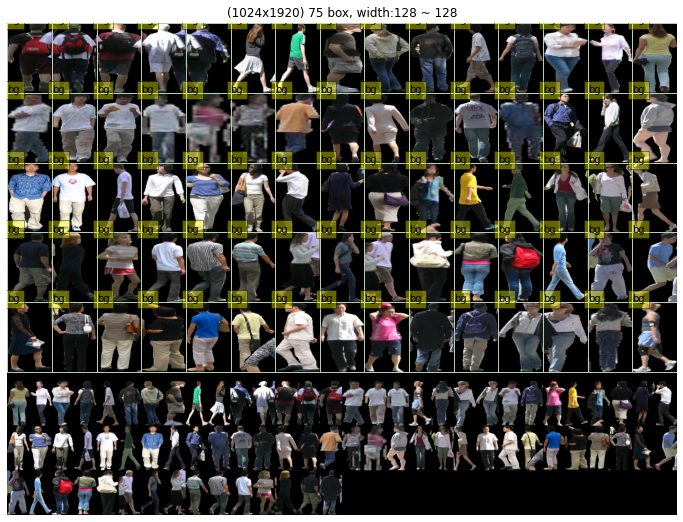

5 [0.]


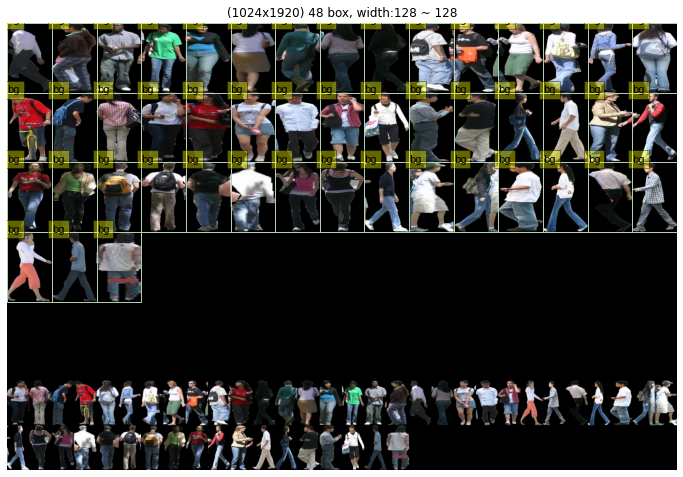

In [239]:
display_data(attach_obj_img, attach_obj_bbox, stride=1)